In [1]:
import cirq
import numpy as np

In [2]:
# setup random circuits
from cirq.experiments import random_quantum_circuit_generation as rqcg

circuits = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20,
    two_qubit_gate=cirq.ISWAP**0.5,
    q0=cirq.GridQubit(4,4),
    q1=cirq.GridQubit(4,5),
)
print(len(circuits))

20


In [3]:
# We will truncate to these lengths
max_depth = 100
cycle_depths = np.arange(3, max_depth, 20)
cycle_depths

array([ 3, 23, 43, 63, 83])

In [4]:
# density matrix simulator
device_name = None

if device_name is None:
    sampler = cirq.DensityMatrixSimulator(noise=cirq.depolarize(5e-3))
else:
    import cirq_google as cg
    sampler = cg.get_engine_sampler(device_name, gate_set_name='sqrt_iswap')
    device = cg.get_engine_device(device_name)

    import cirq.contrib.routing as ccr
    graph = ccr.gridqubits_to_graph_device(device.qubits)
    pos = {q: (q.row, q.col) for q in graph.nodes}
    import networkx as nx
    nx.draw_networkx(graph, pos=pos)

In [5]:
# take data

In [6]:
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuits,
    cycle_depths=cycle_depths,
    repetitions=10_000,
)
sampled_df

100%|███████████████████████████████████████████████████████████| 108/108 [00:27<00:00,  3.93it/s]


,,sampled_probs,timestamp,pair
circuit_i,cycle_depth,,,
0,3,"[0.0339, 0.2709, 0.3128, 0.3824]",1.636396e+09,"((4, 4), (4, 5))"
1,3,"[0.2742, 0.0201, 0.578, 0.1277]",1.636396e+09,"((4, 4), (4, 5))"
2,3,"[0.1486, 0.2665, 0.4269, 0.158]",1.636396e+09,"((4, 4), (4, 5))"
3,3,"[0.0618, 0.2875, 0.3638, 0.2869]",1.636396e+09,"((4, 4), (4, 5))"
4,3,"[0.278, 0.2818, 0.2985, 0.1417]",1.636396e+09,"((4, 4), (4, 5))"
...,...,...,...,...
14,83,"[0.2342, 0.261, 0.2557, 0.2491]",1.636396e+09,"((4, 4), (4, 5))"
15,83,"[0.2766, 0.2699, 0.2145, 0.239]",1.636396e+09,"((4, 4), (4, 5))"
16,83,"[0.2181, 0.2756, 0.2325, 0.2738]",1.636396e+09,"((4, 4), (4, 5))"


In [7]:
# benchmark fidelities

In [8]:
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuits,
    cycle_depths=cycle_depths,
)
fids

,cycle_depth,fidelity,pair
0,3,0.922308,"((4, 4), (4, 5))"
1,23,0.600710,"((4, 4), (4, 5))"
2,43,0.389550,"((4, 4), (4, 5))"
3,63,0.256171,"((4, 4), (4, 5))"
4,83,0.166446,"((4, 4), (4, 5))"


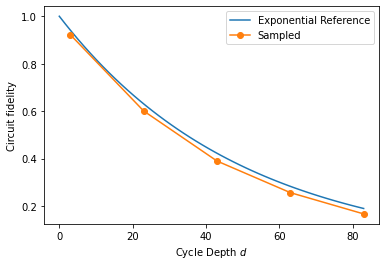

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

# Exponential reference
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1-5e-3)**(4*xx), label=r'Exponential Reference')

def _p(fids):
    plt.plot(fids['cycle_depth'], fids['fidelity'], 'o-', label=fids.name)

fids.name = 'Sampled'
_p(fids)

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')

In [10]:
# optimize PhasedFSimGate Parameters
import multiprocessing
pool = multiprocessing.get_context('spawn').Pool()

In [11]:
from cirq.experiments.xeb_fitting import (
    parameterize_circuit, 
    characterize_phased_fsim_parameters_with_xeb, 
    SqrtISwapXEBOptions,
)

# Set which angles we want to characterize (all)
options = SqrtISwapXEBOptions(
    characterize_theta = True,
    characterize_zeta = True,
    characterize_chi = True,
    characterize_gamma = True,
    characterize_phi = True
)
# Parameterize the sqrt(iswap)s in our circuit library
pcircuits = [parameterize_circuit(circuit, options) for circuit in circuits]

# Run the characterization loop
characterization_result = characterize_phased_fsim_parameters_with_xeb(
    sampled_df,
    pcircuits,
    cycle_depths,
    options,
    pool=pool,
    # ease tolerance so it converges faster:
    fatol=5e-3, 
    xatol=5e-3
)

Simulating with theta =  -0.785 zeta  =       0 chi   =       0 gamma =       0 phi   =       0 
Loss:   0.533
Simulating with theta =  -0.685 zeta  =       0 chi   =       0 gamma =       0 phi   =       0 
Loss:   0.589
Simulating with theta =  -0.785 zeta  =     0.1 chi   =       0 gamma =       0 phi   =       0 
Loss:   0.577
Simulating with theta =  -0.785 zeta  =       0 chi   =     0.1 gamma =       0 phi   =       0 
Loss:   0.563
Simulating with theta =  -0.785 zeta  =       0 chi   =       0 gamma =     0.1 phi   =       0 
Loss:   0.593
Simulating with theta =  -0.785 zeta  =       0 chi   =       0 gamma =       0 phi   =     0.1 
Loss:    0.57
Simulating with theta =  -0.745 zeta  =    0.04 chi   =    0.04 gamma =    -0.1 phi   =    0.04 
Loss:   0.585
Simulating with theta =  -0.869 zeta  =   0.056 chi   =   0.056 gamma =   -0.04 phi   =   0.056 
Loss:    0.58
Simulating with theta =  -0.859 zeta  =  0.0224 chi   =  0.0224 gamma =   0.084 phi   =  0.0224 
Loss:   0.621
S

In [12]:
characterization_result.final_params

{(cirq.GridQubit(4, 4), cirq.GridQubit(4, 5)): {'theta': -0.7691961772982421,
  'zeta': 0.005225762064202399,
  'chi': 0.005501357144003352,
  'gamma': -0.012759620600194352,
  'phi': 0.007901231494445937}}

In [13]:
characterization_result.fidelities_df

,cycle_depth,fidelity,pair
0,3,0.925306,"((4, 4), (4, 5))"
1,23,0.611405,"((4, 4), (4, 5))"
2,43,0.397817,"((4, 4), (4, 5))"
3,63,0.252082,"((4, 4), (4, 5))"
4,83,0.169874,"((4, 4), (4, 5))"


In [14]:
from cirq.experiments.xeb_fitting import before_and_after_characterization
before_after_df = before_and_after_characterization(fids, characterization_result)
before_after_df

,a_0,layer_fid_0,cycle_depths_0,fidelities_0,a_std_0,layer_fid_std_0,a_c,layer_fid_c,cycle_depths_c,fidelities_c,a_std_c,layer_fid_std_c,characterized_angles,theta,zeta,chi,gamma,phi
pair,,,,,,,,,,,,,,,,,,
"((4, 4), (4, 5))",0.983306,0.978796,"[3, 23, 43, 63, 83]","[0.9223078519899042, 0.6007096054303062, 0.389...",0.001361,0.000054,0.988967,0.978941,"[3, 23, 43, 63, 83]","[0.9253058559241214, 0.6114049235772856, 0.397...",0.005576,0.000217,"{'theta': -0.7691961772982421, 'zeta': 0.00522...",-0.769196,0.005226,0.005501,-0.01276,0.007901


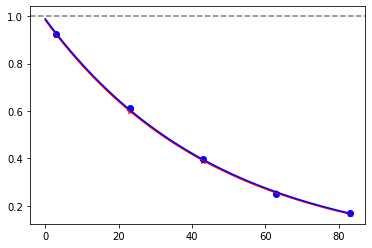

In [15]:
from cirq.experiments.xeb_fitting import exponential_decay

for i, row in before_after_df.iterrows():
    plt.axhline(1, color='grey', ls='--')
    plt.plot(row['cycle_depths_0'], row['fidelities_0'], '*', color='red')
    plt.plot(row['cycle_depths_c'], row['fidelities_c'], 'o', color='blue')

    xx = np.linspace(0, np.max(row['cycle_depths_0']))
    plt.plot(xx, exponential_decay(xx, a=row['a_0'], layer_fid=row['layer_fid_0']), color='red')
    plt.plot(xx, exponential_decay(xx, a=row['a_c'], layer_fid=row['layer_fid_c']), color='blue')

    plt.show()